# Method descriptions

* **centralized** finds global classifier using the centralized data
* **regularised** learns local classifiers keeping them similar to the neighbors' classifiers
* **local** learns independent local classifiers


In [5]:
# imports
from copy import deepcopy
import numpy as np

from statistics import mean

import sys
sys.path.append('../src/')

from classification import get_basis
from evaluation import central_accuracy, degrees
from network import synthetic_graph, true_theta_graph
from optimization import regularized_local_FW, local_FW, global_regularized_local_FW, gd_reg_local_FW, centralized_FW
from related_works import colearning, lafond_FW
from utils import generate_models, generate_samples

import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
# set graph of nodes with local personalized data
NB_ITER = 100
N = 100
D = 20
NOISE_R = 0.05
random_state = 2017
BETA = 1 # if None, simplex constraint
MU = 1

V, theta_true, cluster_indexes = generate_models(nb_clust=1, nodes_per_clust=N, random_state=random_state)
_, X, Y, X_test, Y_test, _, _ = generate_samples(V, theta_true, D, random_state=random_state, sample_error_rate=NOISE_R)

# set graph
nodes, adj_matrix, similarities = synthetic_graph(X, Y, X_test, Y_test, V, theta_true)

# set callbacks for optimization analysis
callbacks = {
    'accuracy': [central_accuracy, []],
    'degrees': [degrees, []],
}

base_clfs = get_basis(n=D+1, d=D+1)


In [7]:
results = {}
hist_accuracies = {}

results = {}
hist_accuracies = {}

nodes_centralized = deepcopy(nodes)
results["centralized"] = centralized_FW(nodes_centralized, base_clfs, nb_iter=NB_ITER, beta=BETA, callbacks=callbacks)
hist_accuracies["centralized"] = accuracies(nodes_centralized)

nodes_regularized = deepcopy(nodes)
results["regularized"] = regularized_local_FW(nodes_regularized, base_clfs, nb_iter=NB_ITER, beta=BETA, mu=MU, callbacks=callbacks)
hist_accuracies["regularized"] = accuracies(nodes_regularized)

nodes_copy = deepcopy(nodes)
results["lafond"] = lafond_FW(nodes_copy, base_clfs, nb_iter=NB_ITER, beta=BETA, callbacks=callbacks)
hist_accuracies["lafond"] = accuracies(nodes_copy)

nodes_copy = deepcopy(nodes)
results["local"] = local_FW(nodes_copy, base_clfs, nb_iter=NB_ITER, beta=BETA, callbacks=callbacks)
hist_accuracies["local"] = accuracies(nodes_copy)

nodes_copy = deepcopy(nodes)
results["global-reg"] = global_regularized_local_FW(nodes_copy, base_clfs, nb_iter=NB_ITER, beta=BETA, callbacks=callbacks)
hist_accuracies["global-reg"] = accuracies(nodes_copy)

gd_nodes = deepcopy(nodes)
results["gd-regularized"] = gd_reg_local_FW(gd_nodes, base_clfs, gd_method={"name":"laplacian", "pace_gd": 30, "args":()}, beta=BETA, mu=0.1, reset_step=False, nb_iter=NB_ITER, callbacks=callbacks)

# colearning results
results["colearning"], clf_colearning = colearning(N, X, Y, X_test, Y_test, D, NB_ITER, adj_matrix, similarities)

# get results with true thetas
true_graph = true_theta_graph(nodes_copy, theta_true)
acc = central_accuracy(true_graph)

print("done")

done


../src/optimization.py:123: RuntimeWarning: invalid value encountered in true_divide
  nei_diff_reg = np.vstack([s*d/norm for s,d,norm in zip(n.sim, nei_diff, nei_diff_norm)])


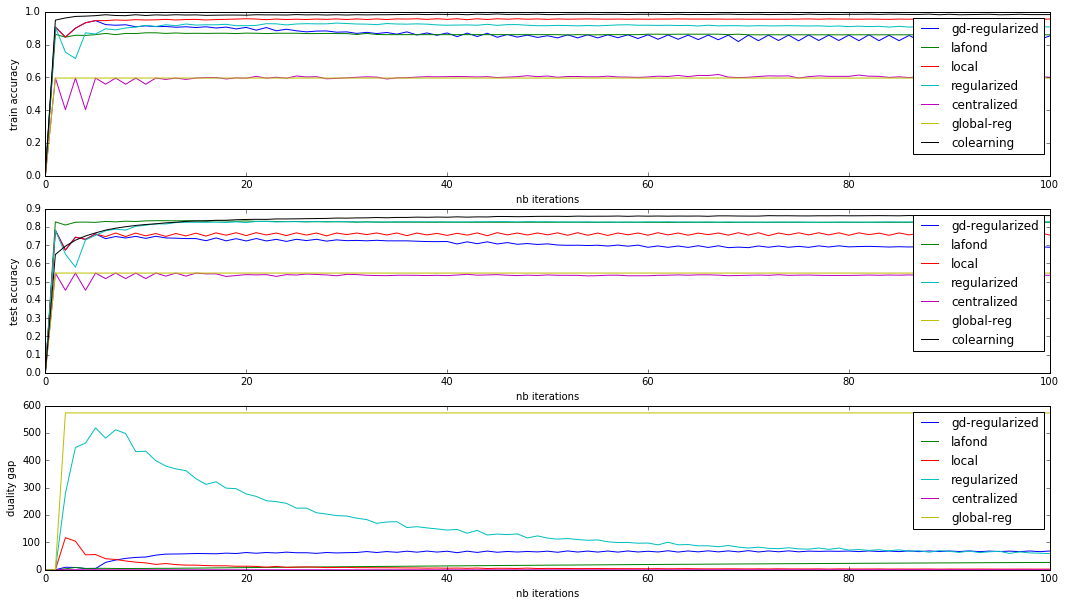

In [28]:
plt.figure(1, figsize=(18, 10))

plt.subplot(311)
plt.xlabel('nb iterations')
plt.ylabel('train accuracy')

for k, r_list in results.items():
    plt.plot(range(len(r_list)), [r['accuracy'][0] for r in r_list], label='{}'.format(k))

plt.legend()

plt.subplot(312)
plt.xlabel('nb iterations')
plt.ylabel('test accuracy')

for k, r_list in results.items():
    plt.plot(range(len(r_list)), [r['accuracy'][1] for r in r_list], label='{}'.format(k))

plt.legend()


plt.subplot(313)
plt.xlabel('nb iterations')
plt.ylabel('duality gap')

for k, r_list in results.items():
    try:
        plt.plot(range(len(r_list)), [r['duality-gap'] for r in r_list], label='{}'.format(k))
    except:
        pass

plt.legend()

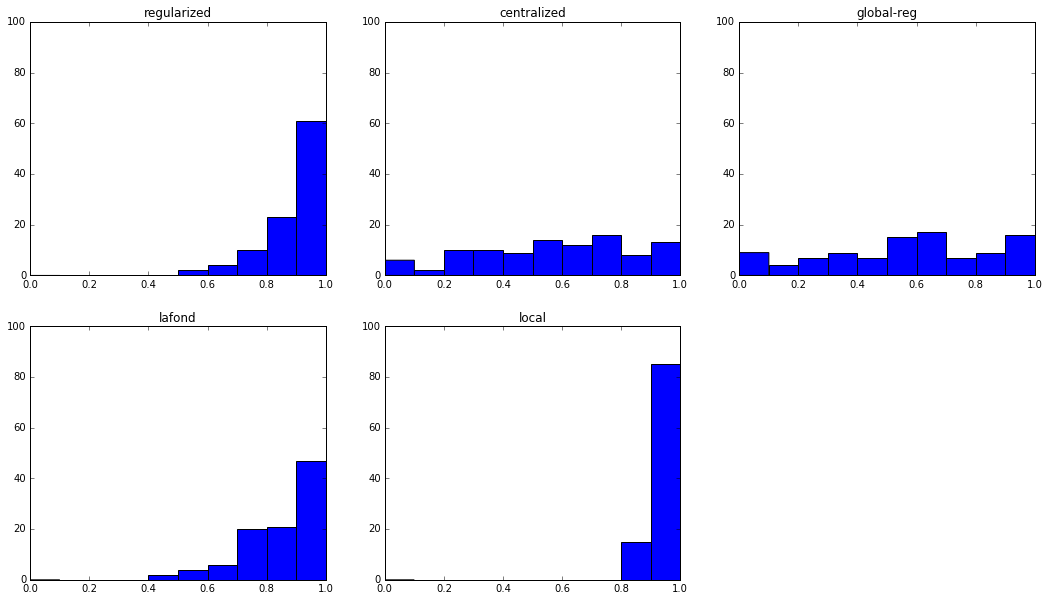

In [9]:
plt.suptitle("Histograms Train Accuracies")
plt.figure(2, figsize=(18, 10))

for i, (k, r_list) in enumerate(hist_accuracies.items()):

    plt.subplot(231 + i)
    plt.title(k)
    plt.ylim(0, N)
    plt.hist(r_list[0], 10, range=(0, 1))

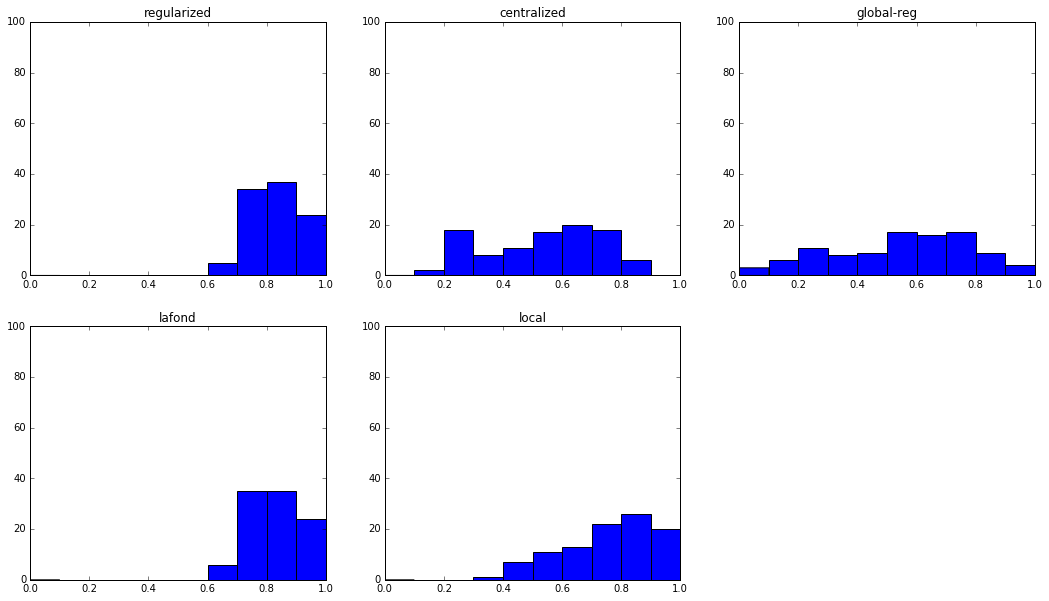

In [10]:
plt.suptitle("Histograms Test Accuracies")

plt.figure(2, figsize=(18, 10))

for i, (k, r_list) in enumerate(hist_accuracies.items()):

    plt.subplot(231 + i)
    plt.title(k)
    plt.ylim(0, N)
    plt.hist(r_list[1], 10, range=(0, 1))